Work out how the PS1 mags convert to TESS mags/counts

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 
from delta_kernal import *

In [2]:
# fraction of PS1 filters that cover TESS from the PS_To_TESS_filter notebook
r = 0.677
i = 0.975
z = 0.977
y = 0.673
factor = [r,i,z,y]
factor = [0.41656058, 1.12264514, 0.95252585, 0.76186266]
def Combined_ps1(Table,Coeff):
    filts = [PS1.rmag.values,PS1.imag.values,PS1.zmag.values,PS1.ymag.values]
    flux = np.zeros_like(PS1.rmag.values)
    for i in range(len(Coeff)):
        flux = 10**(-1/2.5*(filts[i]+48.6)) 
        flux += flux * Coeff[i]
    m = -2.5*np.log10(flux) - 48.6
    T = 10**(-1/2.5*(m-20.44))
    ps_wcs = sd.WCS(f)
    return T

def PS1_to_TESS_mag(PS1):
    """
    https://arxiv.org/pdf/1706.00495.pdf pg.9
    """
    #coeffs = np.array([0.6767,0.9751,0.9773,0.6725])
    g = PS1.gmag.values
    r = PS1.rmag.values
    i = PS1.imag.values
    z = PS1.zmag.values
    y = PS1.ymag.values

    #t = coeffs[0] * r + coeffs[1] * i #+ coeffs[2] * z + coeffs[3] * y
    t = i - 0.00206*(g - i)**3 - 0.02370*(g - i)**2 + 0.00573*(g - i) - 0.3078
    PS1['tmag'] = t
    return PS1

../scenes/syndiff.py:398: RuntimeWarning: invalid value encountered in less
  result = result.iloc[result.tmag.values < magnitude_limit]


417


<IPython.core.display.Javascript object>


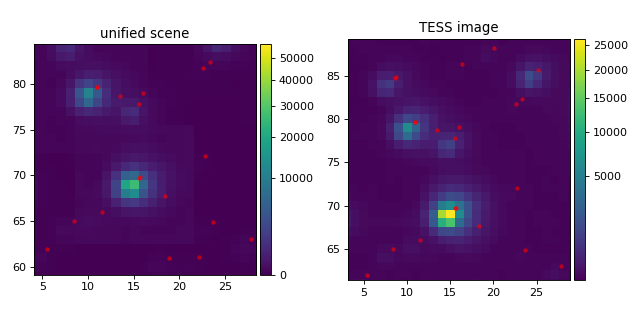

In [4]:
# SN2020fqv
ra = 189.1385827     
dec = 11.2316599
scene = sd.Catalog_scene(ra,dec,100,Maglim=18, Sector=23, Catalog='unified',Interpolate=False,Plot=True)#,Save='PS1_catalog_scene.pdf')

In [12]:
cat = scene['catalog']
tpf = scene['tpf']
fake = scene['sources']

In [11]:
scene.keys()

dict_keys(['catalog', 'tpf', 'sources'])

In [6]:
cat.row

1020      -5.044711
1117      -2.735282
1144      -0.724340
1245       2.919110
1256       4.643869
            ...    
14700    104.665791
14717    109.531516
14749     98.427588
15294     69.699696
15295     69.770007
Name: row, Length: 417, dtype: float64

In [13]:
cus = np.ones_like(tpf.flux[0])
#cus[20:29,20:29] = 0
#cus[45:55,45:55] = 0
bkg = sd.Scene_bkg_estimate(fake,tpf,Limit=.3)#,Custom_mask=cus)

flux = tpf.flux - bkg
f = flux.copy()
f[f<0] = 0
b = bkg.copy()
b[b==0] = np.nan
me = np.nanmedian(b,axis=0)
ind = np.where(np.nansum(b < me,axis=(1,2)) > (b.shape[1]*2))[0]
low_bkg_flux = flux[ind]
low_bkg_flux[low_bkg_flux==0] = np.nan
median = np.nanmedian(low_bkg_flux,axis=0)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


AttributeError: 'numpy.ndarray' object has no attribute 'row'

In [80]:
pos = np.array([cat.col.values,cat.row.values]).T
Tmag = cat.tmag.values
loc,iso,ts = sd.Isolated_stars(pos,Tmag,f,median,fake,Mag=16,Distance=7)

../scenes/utils.py:73: RuntimeWarning: invalid value encountered in less
  median[median<0] = 0


In [91]:
ind = []
for i in range(len(loc)):
    thing = np.where((loc[i,0] == (pos[:,0]-.5).astype('int')) & (loc[i,1] == (pos[:,1]-.5).astype('int')))[0][0]
    ind += [thing]
    
ind = np.array(ind)

In [92]:
ind

array([ 57,  66,  72,  97, 114, 117, 123, 141, 155, 163, 178, 236, 270,
       282, 334, 349, 351, 354, 364, 383, 403])

In [42]:
ts.shape

(21, 1235, 7, 7)

In [208]:
factor = np.array([r,i,z,y])
factor = np.array([0.94691754, 0.98808461, 1.03382218, 1.1097075 ])
filts = np.array([result.rmag.values,result.imag.values,result.zmag.values,result.ymag.values])
flux = np.zeros_like(result.rmag.values)
for i in range(len(factor)):
    f = 10**(-1/2.5*(filts[i]+48.6)) 
    flux += f * factor[i]
m = -2.5*np.log10(flux) - 48.6
T = 10**(-1/2.5*(m-20.44))

In [269]:
def Isolated_lcs(Stars,Trim=0):
    """
    This is busted for some reason, no idea why but nans return -massive number.
    """
    flags = np.zeros((Stars.shape[0]))
    lcs = np.zeros((Stars.shape[0],Stars.shape[1])).astype(int)
    for i in range(len(Stars)):
        star = Stars[i]
        lc = np.nansum(star,axis=(1,2))
        lc[lc==0] = np.nan
        lcm = lc / np.nanmedian(lc)
        bads = np.nansum(lcm>1.2)
        if bads >= 10:
            flags[i] = 1
            
        if Trim > 0:
            lc = np.nansum(star[:,Trim:-Trim,Trim:-Trim],axis=(1,2))
            lc[lc==0] = np.nan
        lcs[i,:] = lc
        print(lc)
    lcs = np.nan
    return lcs, flags.astype(int)

In [270]:
test,flags = Isolated_lcs(ts,2)

[      nan       nan       nan ... 368.05463 364.48712 368.69305]
[      nan       nan       nan ... 671.41064 673.779   672.81635]
[      nan       nan       nan ... 82.944336 81.66767  83.38483 ]
[      nan       nan       nan ... 211.66678 210.6005  210.3044 ]
[      nan       nan       nan ... 47.289413 45.048454 47.29535 ]
[      nan       nan       nan ... 152.99835 154.40636 157.17079]
[      nan       nan       nan ... 307.76566 306.97766 311.8909 ]
[      nan       nan       nan ... 451.9785  452.67398 452.66943]
[      nan       nan       nan ... 143.1889  140.14578 140.79254]
[      nan       nan       nan ... 295.037   301.9312  295.38348]
[      nan       nan       nan ... 3638.2341 3639.9636 3637.6182]
[     nan      nan      nan ... 545.9897 549.3864 550.062 ]
[      nan       nan       nan ... 83.5251   83.405136 84.716156]
[     nan      nan      nan ... 8197.65  8208.346 8197.741]
[      nan       nan       nan ... 219.62363 216.15283 219.69473]
[      nan       nan  

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


In [271]:
test

nan

In [258]:
np.nansum(ts.shape)

(21, 1235, 7, 7)

In [272]:
test = np.nansum(ts[:,:,2:-2,2:-2],axis=(2,3))

In [274]:
test[test==0] = np.nan

In [256]:
test[0]

array([  0,   0,   0, ..., 368, 364, 368])

In [276]:
isomed = np.nanmedian(test,axis=1)
isostd = np.nanstd(test,axis=1)

In [278]:
isomed

array([ 364.84265 ,  673.0426  ,   80.689514,  215.482   ,   47.269455,
        146.7714  ,  312.08887 ,  447.17322 ,  136.8906  ,  298.16055 ,
       3643.9116  ,  545.9891  ,   81.86908 , 8119.24    ,  221.84904 ,
        172.31017 ,  669.70667 ,  105.84128 ,  145.56033 ,  390.2842  ,
         38.272644], dtype=float32)

In [279]:
isostd

array([ 7.0562263, 41.810184 ,  5.1040554,  5.0343575,  3.0908606,
       10.765188 ,  5.4937015,  5.69149  ,  4.6803603,  4.7441845,
       29.84532  ,  4.154262 ,  4.3589263, 65.84057  , 59.823044 ,
        4.531149 ,  5.8421693,  7.885256 ,  4.080264 , 15.905014 ,
        2.9905822], dtype=float32)

In [106]:
catiso = cat.iloc[ind]

In [146]:
g = catiso.gmag.values
r = catiso.rmag.values
i = catiso.imag.values
z = catiso.zmag.values
y = catiso.ymag.values
gaia = catiso.gaiamag.values

ps1 = np.array([g,r,i,z,y])

In [148]:
ps1.shape

(5, 21)

In [149]:
counts = 10**(-2/5*(ps1-25))

In [151]:
counts.shape

(5, 21)

In [123]:
from scipy.optimize import minimize

In [295]:
def fit_gaia(offset,stars,gaia):
    counts = 10**(-2/5*(gaia-offset-20.44))
    res = np.nansum((counts-stars)**2/stars)
    print(res)
    return res

def fit_ps1(coeffs,stars,ps1,starerr):
    counts = 10**(-2/5*(ps1-25))
    counts = np.nansum(coeffs[:,np.newaxis] * counts,axis=0)
    res = np.nansum((counts-stars)**2/starerr**2)
    return res
    

In [163]:
c0 = np.array([0,0,0,0,0])

In [168]:
res = minimize(fit_gaia,.5,args=(isomed,gaia),method = 'Nelder-Mead')
res

8090.10045461956
8072.800295571862
8060.827694534689
8054.576817856809
8060.927560141465
8054.463741282212
8060.927560141465
8053.726163993883
8054.576817856809
8053.892982789763
8053.9563799524485
8053.759514661344
8053.792070575472
8053.730378543613
8053.746763666441
8053.725162790304
8053.730378543613
8053.724887110942
8053.726163993883
8053.724830775582
8053.725162790304
8053.724810412597


 final_simplex: (array([[0.58798828],
       [0.58808594]]), array([8053.72481041, 8053.72483078]))
           fun: 8053.724810412597
       message: 'Optimization terminated successfully.'
          nfev: 22
           nit: 11
        status: 0
       success: True
             x: array([0.58798828])

In [298]:
bds = ((0,1),(0,1),(0,1),(0,1),(0,1))
res = minimize(fit_ps1,c0[1:],args=(isomed,ps1[1:],isostd),bounds=bds[1:])
res

      fun: 16425.19730862078
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00000000e+00, 1.42165478e+04, 2.18812118e+04, 3.63797881e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 140
      nit: 19
   status: 0
  success: True
        x: array([0.01812525, 0.        , 0.        , 0.00301341])

In [133]:
 counts = 10**(-2/5*(gaia-res.x-20.44))

In [134]:
counts - isomed

array([-4.38767023e-06, -2.03425780e+01,  2.81481166e+00, -3.76296445e+01,
        1.52755548e+01, -3.34729601e+01, -1.11528877e+02,  4.72038965e+01,
       -9.87860462e+01, -3.63313165e+01, -7.92317526e+03,  4.44176181e+00,
        1.99475047e+01,             nan, -4.80899436e+01,  2.40796866e+00,
        4.27386862e+01, -4.53686862e+00,  2.14337200e+01, -4.52283359e+01,
        4.90076908e+01])

# Can MCMC do a better job?

hopefully

In [183]:
import emcee

In [206]:
def log_likelihood(coeffs, ps1, star, starerr):
    counts = 10**(-2/5*(ps1-25))
    counts = np.nansum(coeffs[:,np.newaxis] * counts,axis=0)
    model = counts
    sigma2 = starerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def lnprior(theta):
    if (0 <= theta).all() & (theta <= 1).all():
        return 0.0
    return -np.inf

In [ ]:
def lnlike(theta, x, y, yerr,model):
    zp, ak,ag,ar,ai = theta
    y = y + zp #+ ak - ar
    inv_sigma2 = 1.0/(yerr**2 + model**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [ ]:
def fit_ps1(coeffs,stars,ps1):
    counts = 10**(-2/5*(ps1-25))
    counts = np.nansum(coeffs[:,np.newaxis] * counts,axis=0)
    res = np.nansum((counts-stars)**2/stars)
    return res

In [285]:
def lnlike(theta, ps1, stars, stars_er):
    counts = 10**(-2/5*(ps1-20.44))
    counts = np.nansum(theta[:,np.newaxis] * counts,axis=0)
    inv_sigma2 = 1.0/(stars_er**2 + stars**2)
    return -0.5*(np.sum((counts-stars)**2*inv_sigma2 - np.log(inv_sigma2)))

In [194]:
def lnprob(theta, ps1, stars, stars_er):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, ps1, stars, stars_er)

In [286]:
import emcee
ndim, nwalkers = 5, 100
pos = [c0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(ps1, isomed, isostd))
sampler.run_mcmc(pos, 1000);

In [287]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(6000, 5)


In [288]:
labels = ['g','r','i','z','y']

<IPython.core.display.Javascript object>


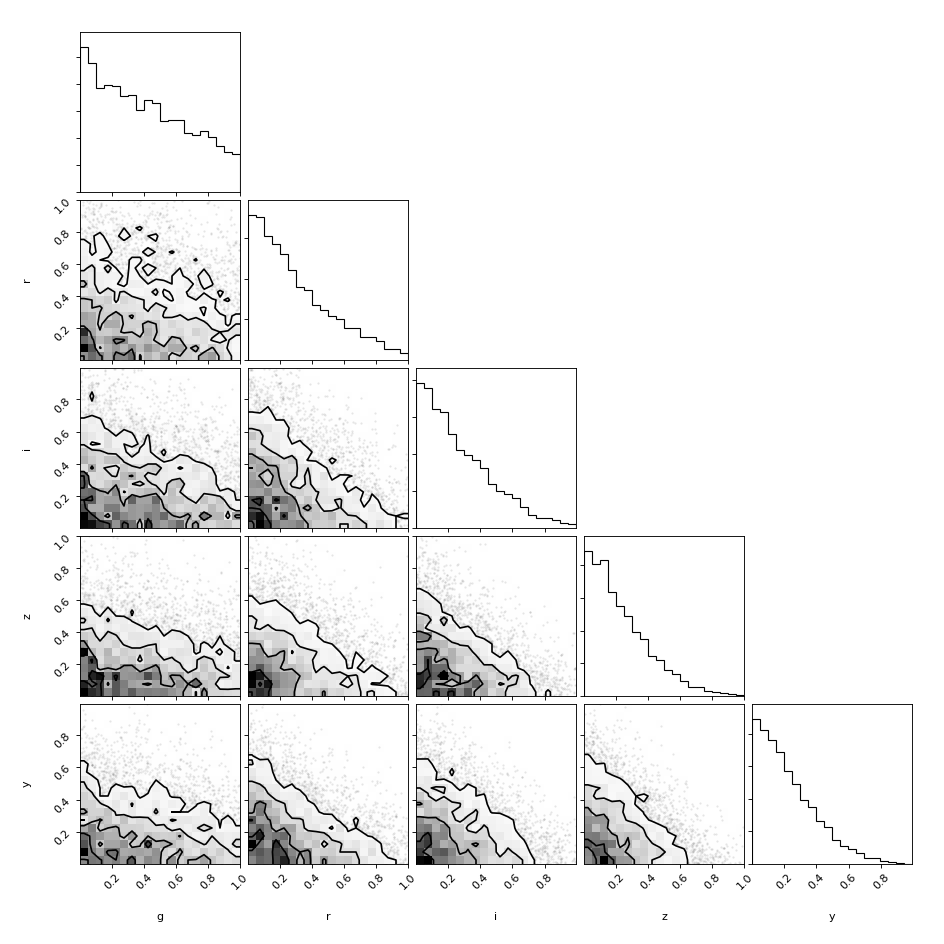

In [289]:
import corner

fig = corner.corner(
    flat_samples, labels=labels
);

In [290]:
isostd

array([ 7.0562263, 41.810184 ,  5.1040554,  5.0343575,  3.0908606,
       10.765188 ,  5.4937015,  5.69149  ,  4.6803603,  4.7441845,
       29.84532  ,  4.154262 ,  4.3589263, 65.84057  , 59.823044 ,
        4.531149 ,  5.8421693,  7.885256 ,  4.080264 , 15.905014 ,
        2.9905822], dtype=float32)

In [291]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>